In [4]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-W2V_cat.csv'

# Read the CSV file
df = pd.read_csv(file_path)
df = df.drop(df.columns[0], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.model_selection import train_test_split


df["word2vec_embeddings"] = df["word2vec_embeddings"].apply(literal_eval).apply(np.array)

# Separating the target variable and embeddings
x = df["word2vec_embeddings"]
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' column from df
z = df.drop(["word2vec_embeddings", "numerical_price"], axis=1)


# Deleting original dataframe for memory purpose
del df

# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# Concatenating the exploded embeddings with the rest of the data
concatenated_df = pd.concat([x, z], axis=1).reset_index(drop=True)

In [6]:
concatenated_df.columns = concatenated_df.columns.astype(str)


x_train, x_test, y_train, y_test = train_test_split(concatenated_df, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]

In [7]:
!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn_mixed(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [8]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Ensure y_train and y_test are 1D arrays
# This step is only necessary if y_train or y_test are not already 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Check the shapes again after any necessary adjustments
print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [9]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_nn_mixed, n_trials=50)

[I 2024-01-07 19:18:32,247] A new study created in memory with name: no-name-aa7df72e-3dbd-4e32-be06-fbf593330f6b


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 19:24:38,738] Trial 0 finished with value: 0.674652236113662 and parameters: {'learning_rate': 0.005914314726903407, 'neurons_layer_1': 80, 'neurons_layer_2': 144, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 90, 'regularization': 'none'}. Best is trial 0 with value: 0.674652236113662.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:47:34,810] Trial 1 finished with value: 0.7191527255095063 and parameters: {'learning_rate': 0.00025279955022634225, 'neurons_layer_1': 640, 'neurons_layer_2': 224, 'neurons_layer_3': 144, 'batch_size': 16, 'epochs': 76, 'regularization': 'l1', 'l1_reg': 1.2900118023129024e-05}. Best is trial 1 with value: 0.7191527255095063.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:49:14,418] Trial 2 finished with value: 0.7067180758467408 and parameters: {'learning_rate': 0.0022657210308418673, 'neurons_layer_1': 224, 'neurons_layer_2': 176, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 48, 'regularization': 'none'}. Best is trial 1 with value: 0.7191527255095063.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:59:19,311] Trial 3 finished with value: 0.6865966748149948 and parameters: {'learning_rate': 0.0042170322706450245, 'neurons_layer_1': 16, 'neurons_layer_2': 336, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 2.1874336431616565e-05}. Best is trial 1 with value: 0.7191527255095063.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 20:22:33,601] Trial 4 finished with value: 0.6356201829533586 and parameters: {'learning_rate': 0.0031895389535027334, 'neurons_layer_1': 640, 'neurons_layer_2': 64, 'neurons_layer_3': 48, 'batch_size': 16, 'epochs': 98, 'regularization': 'l1', 'l1_reg': 0.00140851380672852}. Best is trial 1 with value: 0.7191527255095063.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 20:33:55,245] Trial 5 finished with value: 0.5623702349498212 and parameters: {'learning_rate': 0.0010122527340112146, 'neurons_layer_1': 704, 'neurons_layer_2': 416, 'neurons_layer_3': 16, 'batch_size': 64, 'epochs': 88, 'regularization': 'l2', 'l2_reg': 0.06158570379457061}. Best is trial 1 with value: 0.7191527255095063.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 20:37:21,060] Trial 6 finished with value: 0.7226944960282953 and parameters: {'learning_rate': 0.002515114514053707, 'neurons_layer_1': 464, 'neurons_layer_2': 272, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 60, 'regularization': 'none'}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 20:40:45,926] Trial 7 finished with value: 0.7055822422801958 and parameters: {'learning_rate': 0.006887680292462736, 'neurons_layer_1': 160, 'neurons_layer_2': 144, 'neurons_layer_3': 96, 'batch_size': 16, 'epochs': 30, 'regularization': 'none'}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:07:27,314] Trial 8 finished with value: 0.6963310913355626 and parameters: {'learning_rate': 0.002235901342912352, 'neurons_layer_1': 496, 'neurons_layer_2': 512, 'neurons_layer_3': 48, 'batch_size': 16, 'epochs': 69, 'regularization': 'l1_l2', 'l1_reg': 1.047853081298738e-05, 'l2_reg': 0.00021285850065540235}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:12:02,094] Trial 9 finished with value: 0.5959968173182751 and parameters: {'learning_rate': 0.005177343723905979, 'neurons_layer_1': 144, 'neurons_layer_2': 96, 'neurons_layer_3': 64, 'batch_size': 16, 'epochs': 37, 'regularization': 'l2', 'l2_reg': 0.004029694591747589}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 21:12:54,838] Trial 10 finished with value: -0.000252724445855268 and parameters: {'learning_rate': 0.009614774548798468, 'neurons_layer_1': 400, 'neurons_layer_2': 304, 'neurons_layer_3': 256, 'batch_size': 128, 'epochs': 10, 'regularization': 'l1_l2', 'l1_reg': 0.06528118704188428, 'l2_reg': 1.3406286237728115e-05}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 6ms/step


[I 2024-01-07 21:19:42,672] Trial 11 finished with value: 0.6646911468738854 and parameters: {'learning_rate': 0.00010490445229492215, 'neurons_layer_1': 1024, 'neurons_layer_2': 240, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 66, 'regularization': 'l1', 'l1_reg': 0.000318712432960718}. Best is trial 6 with value: 0.7226944960282953.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 21:25:34,803] Trial 12 finished with value: 0.72869272182998 and parameters: {'learning_rate': 0.0011392993165711019, 'neurons_layer_1': 816, 'neurons_layer_2': 240, 'neurons_layer_3': 176, 'batch_size': 64, 'epochs': 56, 'regularization': 'none'}. Best is trial 12 with value: 0.72869272182998.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:33:44,101] Trial 13 finished with value: 0.717587186063327 and parameters: {'learning_rate': 0.0022459498193665318, 'neurons_layer_1': 896, 'neurons_layer_2': 368, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 51, 'regularization': 'none'}. Best is trial 12 with value: 0.72869272182998.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 21:35:29,087] Trial 14 finished with value: 0.676736339065276 and parameters: {'learning_rate': 0.0036121538435509677, 'neurons_layer_1': 352, 'neurons_layer_2': 16, 'neurons_layer_3': 208, 'batch_size': 64, 'epochs': 34, 'regularization': 'none'}. Best is trial 12 with value: 0.72869272182998.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:46:35,994] Trial 15 finished with value: 0.7060188939963964 and parameters: {'learning_rate': 0.0012684685888934698, 'neurons_layer_1': 784, 'neurons_layer_2': 272, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 59, 'regularization': 'none'}. Best is trial 12 with value: 0.72869272182998.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:48:54,449] Trial 16 finished with value: 0.6860738976421438 and parameters: {'learning_rate': 0.007613377126159533, 'neurons_layer_1': 528, 'neurons_layer_2': 400, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 18, 'regularization': 'none'}. Best is trial 12 with value: 0.72869272182998.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:52:25,070] Trial 17 finished with value: 0.7314899411193287 and parameters: {'learning_rate': 0.0015036016467331302, 'neurons_layer_1': 896, 'neurons_layer_2': 208, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 47, 'regularization': 'none'}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 21:58:00,925] Trial 18 finished with value: -0.00032154139860014476 and parameters: {'learning_rate': 0.0012266277826082593, 'neurons_layer_1': 928, 'neurons_layer_2': 192, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 44, 'regularization': 'l1_l2', 'l1_reg': 0.09766683742129992, 'l2_reg': 1.1132156062465898e-05}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 22:00:21,874] Trial 19 finished with value: 0.4916139957552968 and parameters: {'learning_rate': 0.00406736339321909, 'neurons_layer_1': 816, 'neurons_layer_2': 96, 'neurons_layer_3': 128, 'batch_size': 64, 'epochs': 23, 'regularization': 'l2', 'l2_reg': 0.09411756416959598}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 6ms/step


[I 2024-01-07 22:12:04,658] Trial 20 finished with value: 0.6719911635515802 and parameters: {'learning_rate': 0.005259065657878145, 'neurons_layer_1': 1008, 'neurons_layer_2': 464, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 41, 'regularization': 'none'}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 22:15:40,050] Trial 21 finished with value: 0.7148629441583292 and parameters: {'learning_rate': 0.002761412853832688, 'neurons_layer_1': 544, 'neurons_layer_2': 272, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 59, 'regularization': 'none'}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 22:22:09,768] Trial 22 finished with value: 0.7091472430814074 and parameters: {'learning_rate': 0.0016471935951603168, 'neurons_layer_1': 816, 'neurons_layer_2': 320, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 56, 'regularization': 'none'}. Best is trial 17 with value: 0.7314899411193287.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 22:25:29,406] Trial 23 finished with value: 0.7326111188310149 and parameters: {'learning_rate': 0.0007732476548348156, 'neurons_layer_1': 368, 'neurons_layer_2': 208, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 81, 'regularization': 'none'}. Best is trial 23 with value: 0.7326111188310149.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 22:28:44,437] Trial 24 finished with value: 0.7185571327354529 and parameters: {'learning_rate': 0.0011585458702711947, 'neurons_layer_1': 304, 'neurons_layer_2': 208, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 81, 'regularization': 'none'}. Best is trial 23 with value: 0.7326111188310149.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 22:38:33,926] Trial 25 finished with value: 0.7312254660900492 and parameters: {'learning_rate': 0.0005876133844072576, 'neurons_layer_1': 912, 'neurons_layer_2': 160, 'neurons_layer_3': 160, 'batch_size': 64, 'epochs': 84, 'regularization': 'none'}. Best is trial 23 with value: 0.7326111188310149.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 22:45:23,436] Trial 26 finished with value: 0.7360264712696436 and parameters: {'learning_rate': 0.000371029603966771, 'neurons_layer_1': 944, 'neurons_layer_2': 160, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 100, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 22:49:34,102] Trial 27 finished with value: 0.6433262544558922 and parameters: {'learning_rate': 0.001772544607023582, 'neurons_layer_1': 288, 'neurons_layer_2': 112, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 100, 'regularization': 'l1_l2', 'l1_reg': 0.00453055366396909, 'l2_reg': 0.0010068440742626891}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 22:54:31,713] Trial 28 finished with value: 0.6827454615896047 and parameters: {'learning_rate': 0.0001696553648268681, 'neurons_layer_1': 720, 'neurons_layer_2': 32, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 95, 'regularization': 'l2', 'l2_reg': 0.0072952055848028}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 23:07:25,790] Trial 29 finished with value: 0.7073513541939063 and parameters: {'learning_rate': 0.006379934331994334, 'neurons_layer_1': 592, 'neurons_layer_2': 144, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 92, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:14:10,097] Trial 30 finished with value: 0.7041955040786246 and parameters: {'learning_rate': 0.003106727355546817, 'neurons_layer_1': 944, 'neurons_layer_2': 192, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 79, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:20:15,883] Trial 31 finished with value: 0.7283693765561369 and parameters: {'learning_rate': 0.0006807772853527204, 'neurons_layer_1': 880, 'neurons_layer_2': 160, 'neurons_layer_3': 160, 'batch_size': 128, 'epochs': 84, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:25:00,886] Trial 32 finished with value: 0.725682808449975 and parameters: {'learning_rate': 0.000630525858355866, 'neurons_layer_1': 736, 'neurons_layer_2': 128, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 87, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:36:00,981] Trial 33 finished with value: 0.7158703173075684 and parameters: {'learning_rate': 0.001662100100200244, 'neurons_layer_1': 960, 'neurons_layer_2': 208, 'neurons_layer_3': 144, 'batch_size': 64, 'epochs': 92, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:41:24,244] Trial 34 finished with value: 0.6721925667648639 and parameters: {'learning_rate': 0.0005791408628595322, 'neurons_layer_1': 864, 'neurons_layer_2': 176, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 75, 'regularization': 'l1', 'l1_reg': 0.00011081354346660246}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 23:48:20,051] Trial 35 finished with value: 0.7237312900246453 and parameters: {'learning_rate': 0.001851508953449707, 'neurons_layer_1': 416, 'neurons_layer_2': 64, 'neurons_layer_3': 176, 'batch_size': 32, 'epochs': 65, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 23:55:00,611] Trial 36 finished with value: 0.7294092041211249 and parameters: {'learning_rate': 0.00010289730889425275, 'neurons_layer_1': 640, 'neurons_layer_2': 240, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 100, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 00:05:58,338] Trial 37 finished with value: 0.5361670815673342 and parameters: {'learning_rate': 0.0005794870145939841, 'neurons_layer_1': 976, 'neurons_layer_2': 160, 'neurons_layer_3': 160, 'batch_size': 64, 'epochs': 79, 'regularization': 'l1', 'l1_reg': 0.011980454781323724}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-08 00:12:05,699] Trial 38 finished with value: 0.7172580936498607 and parameters: {'learning_rate': 0.004375727183747793, 'neurons_layer_1': 688, 'neurons_layer_2': 224, 'neurons_layer_3': 192, 'batch_size': 128, 'epochs': 86, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 00:14:44,536] Trial 39 finished with value: 0.6447378986578729 and parameters: {'learning_rate': 0.0030112722038184024, 'neurons_layer_1': 224, 'neurons_layer_2': 80, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 71, 'regularization': 'l2', 'l2_reg': 0.00012223185224631607}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-08 00:25:24,939] Trial 40 finished with value: 0.6930723787807936 and parameters: {'learning_rate': 0.002185740172328827, 'neurons_layer_1': 32, 'neurons_layer_2': 128, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 96, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 00:31:26,598] Trial 41 finished with value: 0.7304908911792051 and parameters: {'learning_rate': 0.00011696631834726004, 'neurons_layer_1': 624, 'neurons_layer_2': 240, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 98, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 00:42:30,110] Trial 42 finished with value: 0.72918774616928 and parameters: {'learning_rate': 0.0008471978751306264, 'neurons_layer_1': 864, 'neurons_layer_2': 304, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 89, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 00:48:42,717] Trial 43 finished with value: 0.7271792566326895 and parameters: {'learning_rate': 0.0014799724545595902, 'neurons_layer_1': 768, 'neurons_layer_2': 192, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 95, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-08 00:51:22,662] Trial 44 finished with value: 0.7124073369689642 and parameters: {'learning_rate': 0.0004860141381050044, 'neurons_layer_1': 416, 'neurons_layer_2': 240, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 47, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 01:13:08,136] Trial 45 finished with value: 0.48781446199768397 and parameters: {'learning_rate': 0.009771021185928354, 'neurons_layer_1': 464, 'neurons_layer_2': 160, 'neurons_layer_3': 160, 'batch_size': 16, 'epochs': 82, 'regularization': 'l1_l2', 'l1_reg': 0.0001362061491919957, 'l2_reg': 0.014133855187517995}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-08 01:29:27,376] Trial 46 finished with value: 0.30677296665854464 and parameters: {'learning_rate': 0.008252637885496685, 'neurons_layer_1': 1024, 'neurons_layer_2': 256, 'neurons_layer_3': 96, 'batch_size': 64, 'epochs': 91, 'regularization': 'l1', 'l1_reg': 0.01421767011783299}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 01:34:19,341] Trial 47 finished with value: 0.7285735538260731 and parameters: {'learning_rate': 0.0009680884614941456, 'neurons_layer_1': 592, 'neurons_layer_2': 288, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 66, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-08 01:41:14,797] Trial 48 finished with value: 0.7326333270883989 and parameters: {'learning_rate': 0.0025645376383726963, 'neurons_layer_1': 912, 'neurons_layer_2': 352, 'neurons_layer_3': 32, 'batch_size': 128, 'epochs': 76, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-08 01:52:56,859] Trial 49 finished with value: 0.728239981418555 and parameters: {'learning_rate': 0.002228999900569848, 'neurons_layer_1': 912, 'neurons_layer_2': 352, 'neurons_layer_3': 80, 'batch_size': 64, 'epochs': 77, 'regularization': 'none'}. Best is trial 26 with value: 0.7360264712696436.


<ipython-input-10-934d0b211bde>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

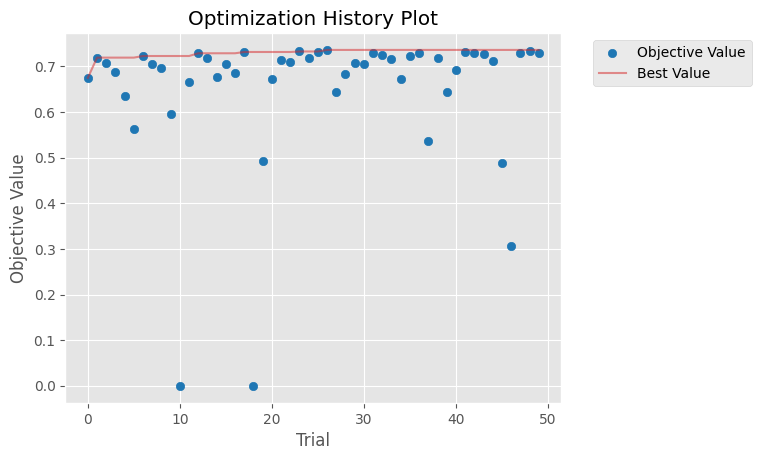

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

<ipython-input-11-1eb49e18946d>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-11-1eb49e18946d>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


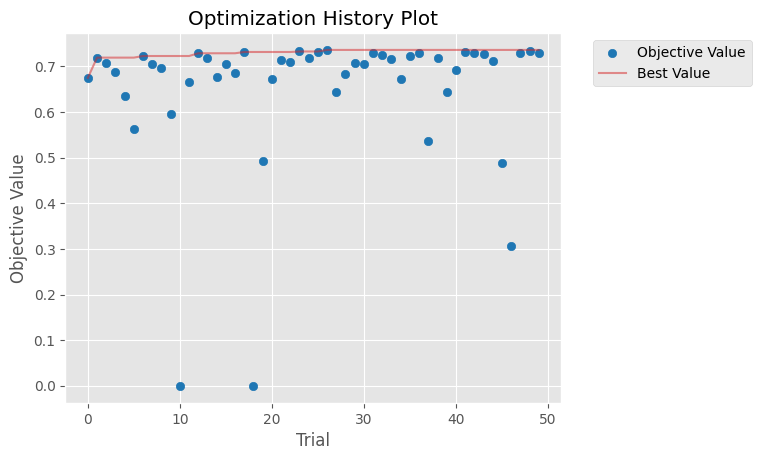

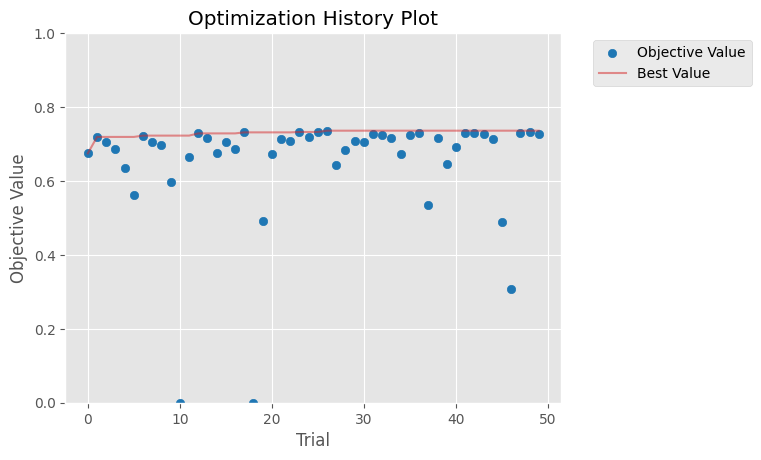

In [11]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 1)

plt.show()